# Omnigot One-Shot

In [1]:
import tensorflow as tf
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import copy
import cv2
from scipy.spatial import distance

In [2]:
import vbranch
from vbranch.data import Omniglot

In [3]:
save = True
model_id = 1

## Load Data

In [4]:
if not os.path.isdir('./omniglot/python/images_background'):
    with zipfile.ZipFile('./omniglot/python/images_background.zip','r') as zip_ref:
        zip_ref.extractall('./omniglot/python')
        
if not os.path.isdir('./omniglot/python/images_evaluation'):
    with zipfile.ZipFile('./omniglot/python/images_evaluation.zip','r') as zip_ref:
        zip_ref.extractall('./omniglot/python')

In [5]:
train_generator = Omniglot('./omniglot/python/images_background/')
test_generator = Omniglot('./omniglot/python/images_evaluation')

In [6]:
batch = train_generator.next(4, 4, 4, flatten=False)

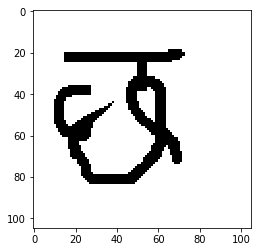

In [7]:
plt.imshow(batch[2, 3, 0].squeeze(), cmap=plt.cm.gray)
plt.show()

## Build Model

In [8]:
EPOCHS = 60
STEPS_PER_EPOCH = 100
model_path = './models/model_' + str(model_id)
A, P, K = 8, 8, 4 # triplet batch specs
output_dim = 128
input_dim = [None, 105, 105, 1]

In [9]:
if not os.path.isdir('./models'):
    os.system('mkdir models')

In [10]:
def batch_gen(A, P, K):
    def func():
        while True:
            batch = train_generator.next(A, P, K)
            batch = batch.astype('float32')
            yield batch
    return func

In [11]:
tf.reset_default_graph()

train_dataset = tf.data.Dataset.from_generator(batch_gen(A, P, K), 'float32', 
                                                 output_shapes=input_dim)

# Dataset for feeding non-triplet batched images from memory
x = tf.placeholder('float32', input_dim, name='x')
batch_size = tf.placeholder('int64', name='batch_size')
test_dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)

iter_ = tf.data.Iterator.from_structure('float32', input_dim)
train_init_op = iter_.make_initializer(train_dataset)
test_init_op = iter_.make_initializer(test_dataset, name='test_init_op')

inputs = iter_.get_next()

In [12]:
with tf.variable_scope('model_' + str(model_id)):
    model = vbranch.models.simple_cnn(inputs, output_dim, 32, 64, 128, 256)

In [13]:
model.summary()

i   Layer name          Output shape        Parameters                    Num param 
------------------------------------------------------------------------------------
    Input               [None,105,105,1]                                            
------------------------------------------------------------------------------------
0   conv2d_1_1          [None,103,103,32]   (3,3,1,32) (32,)              320       
------------------------------------------------------------------------------------
1   bn_1_1              [None,103,103,32]   (32,) (32,)                   64        
------------------------------------------------------------------------------------
2   relu_1_1            [None,103,103,32]                                 0         
------------------------------------------------------------------------------------
3   conv2d_1_2          [None,101,101,32]   (3,3,32,32) (32,)             9248      
-----------------------------------------------------------------

In [14]:
def lr_exp_decay_scheduler(init_lr, t0, decay):
    """NOTE: `episode` starts from 1"""
    def func(episode):
        if episode < t0:
            return init_lr
        lr = init_lr * np.power(decay, (episode - t0) / 2)
        return lr
    return func

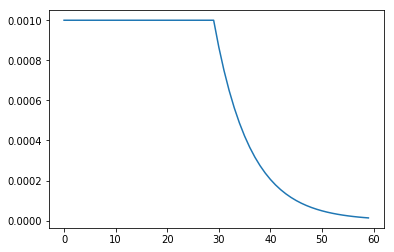

In [15]:
lr_scheduler = lr_exp_decay_scheduler(0.001, EPOCHS // 2, 0.75)
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)

In [16]:
loss = vbranch.losses.triplet_omniglot(model.output, A, P, K, 'loss')
lr = tf.placeholder('float32', name='lr')
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(train_init_op)

    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH)
        
        learning_rate = lr_scheduler(e + 1)
        for i in range(STEPS_PER_EPOCH):
            _, loss_value = sess.run([train_op, loss], feed_dict={lr:learning_rate})
            progbar.update(i + 1, values=[('loss', loss_value), ('lr', learning_rate)])
    
    if save:
        saver = tf.train.Saver()
        path = os.path.join(model_path, 'ckpt')
        saver.save(sess, path)

Epoch 1/60
100/100 [==============================] - 65s 655ms/step - loss: 158.7531 - lr: 0.0010
Epoch 2/60
100/100 [==============================] - 39s 386ms/step - loss: 32.9269 - lr: 0.0010
Epoch 3/60
100/100 [==============================] - 39s 386ms/step - loss: 25.5741 - lr: 0.0010
Epoch 4/60
100/100 [==============================] - 39s 386ms/step - loss: 19.6124 - lr: 0.0010
Epoch 5/60
100/100 [==============================] - 39s 385ms/step - loss: 16.7604 - lr: 0.0010
Epoch 6/60
100/100 [==============================] - 39s 386ms/step - loss: 15.5771 - lr: 0.0010
Epoch 7/60
100/100 [==============================] - 39s 389ms/step - loss: 14.4724 - lr: 0.0010
Epoch 8/60
100/100 [==============================] - 39s 386ms/step - loss: 13.1653 - lr: 0.0010
Epoch 9/60
100/100 [==============================] - 39s 386ms/step - loss: 12.3306 - lr: 0.0010
Epoch 10/60
100/100 [==============================] - 39s 386ms/step - loss: 12.2888 - lr: 0.0010
Epoch 11/60
100/10

## Model Ensemble

In [ ]:
def restore_sess(sess, model_path):
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

In [ ]:
def get_run(n_run):
    all_runs = './omniglot/python/one-shot-classification/all_runs'
    
    if not os.path.isdir(all_runs):
        with zipfile.ZipFile(all_runs + '.zip','r') as zip_ref:
            zip_ref.extractall(all_runs)
    
    run_path = os.path.join(all_runs,'run%02d'%n_run,'class_labels.txt')
    with open(run_path) as f:
        content = f.read().splitlines()

    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]

    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()
    
    def f_load(f):
        path = os.path.join(all_runs, f)
        return cv2.imread(path)[..., 0]

    train_imgs = np.stack([f_load(f) for f in train_files]).\
                        astype('float32')[..., np.newaxis]
    test_imgs  = np.stack([f_load(f) for f in test_files]).\
                        astype('float32')[..., np.newaxis]

    return train_files, test_files, train_imgs, test_imgs, answers_files

In [ ]:
def compute_one_shot_acc(test_pred, train_pred, train_files, answers_files):
    n_test = len(test_pred)
    n_train = len(train_pred)
    
    distM = np.zeros((n_test, n_train))
    for i in range(n_test):
        for c in range(n_train):
            distM[i,c] = distance.euclidean(test_pred[i],train_pred[c])
            
    YHAT = np.argmin(distM, axis=1)
    
    # compute the error rate
    correct = 0.0
    for i in range(n_test):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
        
    return correct / n_test

In [ ]:
total_runs = 20
train_pred_runs = [[] for _ in range(total_runs)]
test_pred_runs = [[] for _ in range(total_runs)]

run_data = [get_run(r+1) for r in range(total_runs)]

num_models = 1

for i in range(len(graphs)):
    with tf.Session() as sess:
        restore_sess(sess, './models/model_' + str(i + 1))
        
        for r in range(total_runs):
            train_files,test_files,train_imgs,test_imgs,answers_files = run_data[r]
            
            feed_dict = {'x:0':train_imgs, 'batch_size:0':len(train_imgs)}
            sess.run('test_init_op', feed_dict=feed_dict)
            train_pred_runs[r].append(sess.run('model_%d'%(i+1)+'/'+'output:0'))
    
            feed_dict = {'x:0':test_imgs, 'batch_size:0':len(test_imgs)}
            sess.run('test_init_op', feed_dict=feed_dict)
            test_pred_runs[r].append(sess.run('model_%d'%(i+1)+'/'+'output:0'))

In [ ]:
acc_runs = []
for r in range(total_runs):
    test_embed = np.mean(test_pred_runs[r], axis=0)
    train_embed = np.mean(train_pred_runs[r], axis=0)
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]
    
    acc = compute_one_shot_acc(test_embed, train_embed,train_files, answers_files)
    acc_runs.append(acc)

In [ ]:
print(acc_runs)
print(np.mean(acc_runs))